In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# 3. Dataset Path
DATASET_PATH = '/content/drive/MyDrive/deepfake_detection_dataset_urdu'


In [4]:
# 4. Load File Paths and Labels
def get_audio_paths_and_labels(dataset_path):
    wav_files = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                if "Bonafide" in file_path:
                    label = 0
                elif "Tacotron" in file_path or "VITS" in file_path:
                    label = 1
                else:
                    continue
                wav_files.append(file_path)
                labels.append(label)
    return wav_files, np.array(labels)

file_paths, labels = get_audio_paths_and_labels(DATASET_PATH)


In [5]:
# 5. Feature Extraction Functions
def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_mel(file_path, sr=16000, n_mels=40):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    return np.mean(mel_db, axis=1)

def extract_chroma(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma, axis=1)

def extract_features(file_paths, feature_type='mfcc'):
    features = []
    for path in tqdm(file_paths, desc=f"Extracting {feature_type.upper()}"):
        try:
            if feature_type == 'mfcc':
                feat = extract_mfcc(path)
            elif feature_type == 'mel':
                feat = extract_mel(path)
            elif feature_type == 'chroma':
                feat = extract_chroma(path)
            features.append(feat)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)


In [6]:
# 6. Train and Evaluate MLP Model
def train_mlp(X, y, feature_name):
    print(f"\nTraining MLP on {feature_name.upper()} Features")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    input_dim = X_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)

    print("\n--- Classification Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bonafide", "Fake"], yticklabels=["Bonafide", "Fake"])
    plt.title(f"{feature_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model

MFCC

Extracting MFCC: 100%|██████████| 5108/5108 [39:30<00:00,  2.15it/s]



Training MLP on MFCC Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.9785
Precision: 0.9611
Recall   : 0.9774
F1-Score : 0.9692
AUC      : 0.9977

Confusion Matrix:
[[654  14]
 [  8 346]]


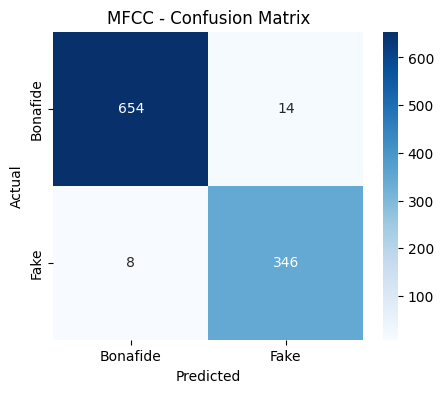

In [7]:
X_mfcc = extract_features(file_paths, 'mfcc')
mlp_mfcc = train_mlp(X_mfcc, labels, 'mfcc')

Mel Spectrogram

Extracting MEL: 100%|██████████| 5108/5108 [01:15<00:00, 67.81it/s]



Training MLP on MEL Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.9677
Precision: 0.9791
Recall   : 0.9266
F1-Score : 0.9521
AUC      : 0.9917

Confusion Matrix:
[[661   7]
 [ 26 328]]


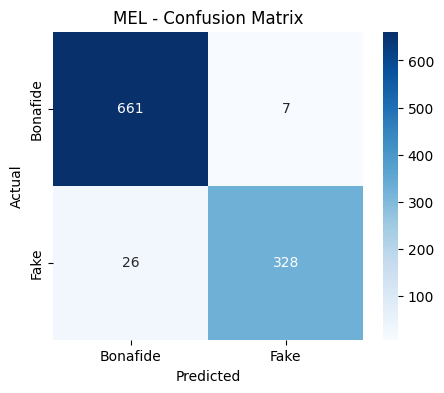

In [9]:
X_mel = extract_features(file_paths, 'mel')
mlp_mel = train_mlp(X_mel, labels, 'mel')

chroma

Extracting CHROMA: 100%|██████████| 5108/5108 [01:50<00:00, 46.24it/s]



Training MLP on CHROMA Features
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Classification Metrics ---
Accuracy : 0.9129
Precision: 0.9431
Recall   : 0.7966
F1-Score : 0.8637
AUC      : 0.9485

Confusion Matrix:
[[651  17]
 [ 72 282]]


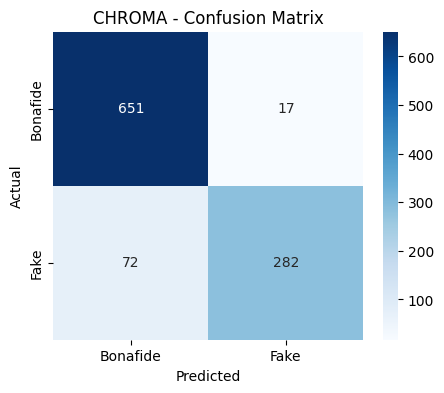

In [10]:
X_chroma = extract_features(file_paths, 'chroma')
mlp_chroma = train_mlp(X_chroma, labels, 'chroma')

## Final Report: Multilayer Perceptron on Urdu Deepfake Detection

We evaluated a multilayer perceptron (MLP) on three types of audio features: MFCC, Mel Spectrogram, and Chroma. The MLP consisted of two hidden layers with ReLU activation and dropout for regularization.

### Key Findings:
- **MFCC features gave the best results**, achieving 97.85% accuracy and an AUC of 0.9977.
- **Mel Spectrogram features also performed very well**, with higher precision but slightly lower recall than MFCC.
- **Chroma features were significantly less effective**, especially in recall, making them less reliable on their own.

These results confirm that MFCC and Mel Spectrogram are highly effective features for detecting deepfake Urdu audio. Chroma may still be useful as part of a combined feature approach.

Future work can explore:
- Feature fusion (e.g., MFCC + Mel)
- Advanced architectures (e.g., CNNs, attention-based models)
- Speaker-independent splits and cross-validation for further generalization analysis
